# Statement

We are going to practice and become familiar with clustering algorithms.

Level 1

- Exercise 1
Cluster the different volumes using the K-means algorithm.

Level 2

- Exercise 2
Group the different volumes using the hierarchical clustering algorithm.

Level 3

- Exercise 3
Calculate the performance of clustering using a parameter such as silhouette.


# Data PreProcessing. 🤖

Same as before tasks.

In [1]:
# Load libraries
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Import Application PCA 
from sklearn.decomposition import PCA

# Import k-means 
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Import DBSCAN
from sklearn.cluster import DBSCAN

#Load Personal library
import Pers_lib as Pers # Import Personal functions ( my functions :) )

# settings to display all columns (default is 20, now is None (all))
pd.set_option("display.max_columns", None)

In [2]:
# Load dataset
df = pd.read_csv('..\Data\DelayedFlights.csv')

In [3]:
# Delete columns that we find not relevant for our model.
try:
    # Let's clean first column that is repeated index.
    df = df.drop(columns ='Unnamed: 0')
    # Let's delete FlightNum and TailNum as these columns doesn't give us any useful information.
    df = df.drop(columns=['FlightNum','TailNum'])
    # Let's delete Origin and Dest as this info is already in Distance column.
    df = df.drop(columns=['Origin','Dest'])
    # Finally, let's drop the columns of Delays that are not ArrDelay, because ArrDelay is the sum of all others, and we don't think that 
    # the information of what kind of delay is, will be relevant, what is sure is that they are going to be completely dependent 
    # (the sum of them are equal to ArrDelay).
    df = df.drop(columns=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'])
    # If we delete the NaN's, the Cancellation and Diverted Columns have been deleted.
    # That means that when whe have deleted NaN's registers, we have deleted the information of cancelled or diverted flights.  
    # As they were so few, is ok to delete them. But also they could be useful for another exploration. 
    # In other dataset / practice we could only extract the cancelled / diverted flights to arrive to interesting conclusions. 
    df = df.drop(columns=['Cancelled','CancellationCode','Diverted'])
    # We keep 'DepDelay' column in order to do clustering - another test would be to delete it to see if model is more accurate.
    # df = df.drop(columns=['DepDelay'])
    
except:
    print("Columns already deleted")

# Drop all NaNs (as explained in S0901, the % of NaNs is very little in all the columns (0.4% max).   )
list_cols = df.columns
array_cols = list_cols.values
NumTotalRegisters = df.shape[0]
df = df.dropna(subset=array_cols)
print(f"Number of registers deleted are {NumTotalRegisters-df.shape[0]}")
print(f"% of registers with NaNs deleted are {((NumTotalRegisters-df.shape[0])/NumTotalRegisters)*100:.2f}%")

# Delete duplicates
index_dupl_df = df.duplicated()
print("Num. duplicates =", index_dupl_df.sum())
# As there are very few duplicates, we took them off.
df.drop_duplicates(inplace= True)

# We left the columns Year / Month / Day of Month as they come, in order to keep them as numerical and cluster them.
# Create column Date of the flight and delete the columns Year / Month / Day of Month. We also keep DayOfWeek.

Number of registers deleted are 8387
% of registers with NaNs deleted are 0.43%
Num. duplicates = 3


#### Sampling
We are going to sample our data, a total of 1% random, stratifying by airline.

In [4]:
NumTotalRegisters = df.shape[0]
NumTotalRegisters
TotalSample = NumTotalRegisters * 0.01
AirlinesCounts = pd.DataFrame(df.UniqueCarrier.value_counts())
AirlinesCounts['Proportion']=AirlinesCounts['UniqueCarrier'] / NumTotalRegisters
AirlinesCounts['Samples'] = round(AirlinesCounts.Proportion *TotalSample)

df_sample = pd.DataFrame()
for Airline in AirlinesCounts.index:
    NumSamples = int(AirlinesCounts.loc[[Airline],:].Samples)
    df_sample = df_sample.append(df[df.UniqueCarrier == Airline].sample(NumSamples,random_state=1))

#### Correlation Matrix
Let's plot the correlation matrix of all the variables.

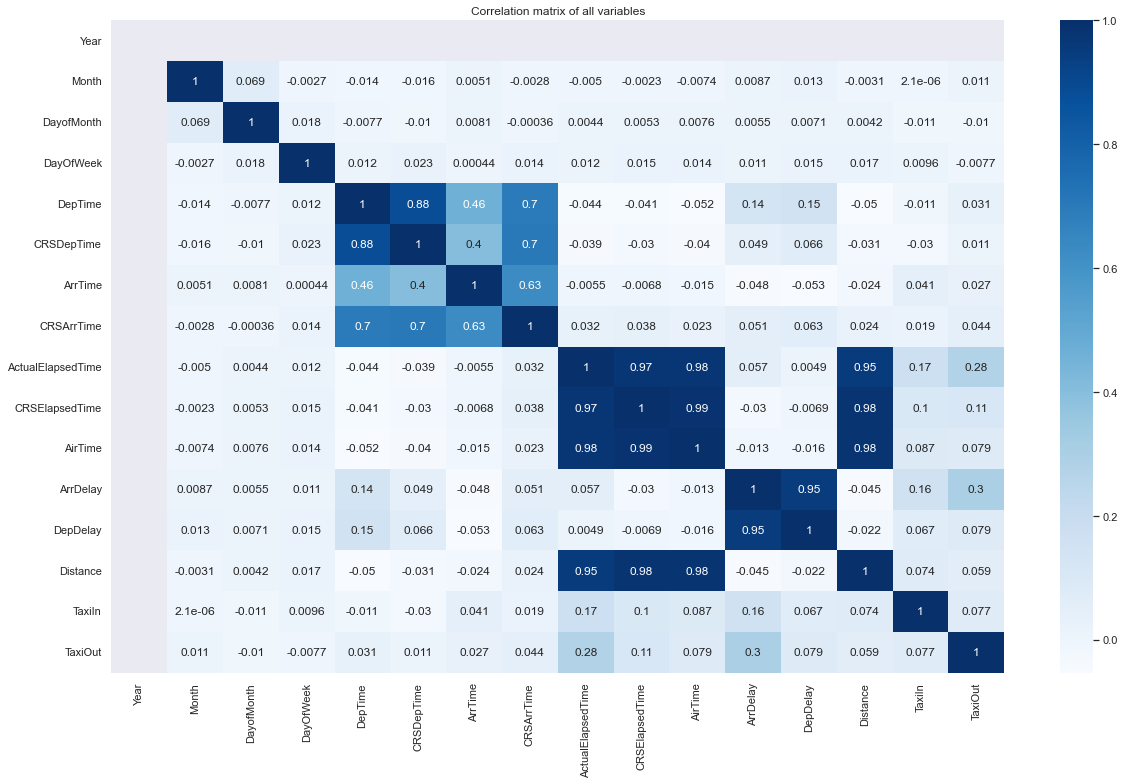

In [5]:
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('Correlation matrix of all variables')
corrMatrix = df_sample.corr()
sns.heatmap(corrMatrix, annot=True, cmap="Blues")
plt.show()

Here we see that our target **ArrDelay** now doesn't have a very clear dependency with any of our features, max is 0.3 with TaxiOut.  
Let's continue with our pre-processing process.

Finally, let's standardize all numerical columns and OHE the Carrier column.

In [6]:
# Standardize df_sample
# list for cols to scale (even day of week).
cols_to_scale = df_sample._get_numeric_data().columns
# create and fit scaler
scaler = StandardScaler()
scaler.fit(df_sample[cols_to_scale])
# scale selected data
df_sample[cols_to_scale] = scaler.transform(df_sample[cols_to_scale])
# Show head df
df_sample.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut
1533757,0.0,1.121456,0.022120,0.010714,0.466659,0.431571,0.425856,0.381125,WN,-0.795755,-0.761680,-0.760614,-0.142721,-0.092229,-0.688341,0.789406,-0.649418
1103252,0.0,0.259592,0.815988,-0.490734,0.893527,0.917609,0.777651,0.823735,WN,-0.781888,-0.761680,-0.658966,-0.384707,-0.371925,-0.627480,-0.340641,-0.649418
591899,0.0,-0.602273,0.475759,1.515058,1.190770,1.344375,1.087303,1.115209,WN,-0.837358,-0.831776,-0.717051,-0.496393,-0.511773,-0.676169,-0.905665,-0.437526
593783,0.0,-0.602273,0.702578,-0.992182,0.240933,0.360444,0.552282,0.586237,WN,-0.379729,-0.411204,-0.324977,-0.626693,-0.711555,-0.154505,-0.340641,-0.225635
903004,0.0,-0.027696,0.248939,-0.490734,0.947165,1.071719,0.805135,0.845325,WN,-0.906696,-0.971966,-0.862263,-0.291635,-0.391903,-0.843101,-0.905665,-0.084373


In [7]:
# Get dummies of all unique values of attribute UniqueCarrier.
df_sample = pd.get_dummies(df_sample,columns=['UniqueCarrier'])


In [8]:
print("Number of columns ",df_sample.columns.size)
df_sample.head()

Number of columns  36


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
1533757,0.0,1.121456,0.022120,0.010714,0.466659,0.431571,0.425856,0.381125,-0.795755,-0.761680,-0.760614,-0.142721,-0.092229,-0.688341,0.789406,-0.649418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1103252,0.0,0.259592,0.815988,-0.490734,0.893527,0.917609,0.777651,0.823735,-0.781888,-0.761680,-0.658966,-0.384707,-0.371925,-0.627480,-0.340641,-0.649418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
591899,0.0,-0.602273,0.475759,1.515058,1.190770,1.344375,1.087303,1.115209,-0.837358,-0.831776,-0.717051,-0.496393,-0.511773,-0.676169,-0.905665,-0.437526,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
593783,0.0,-0.602273,0.702578,-0.992182,0.240933,0.360444,0.552282,0.586237,-0.379729,-0.411204,-0.324977,-0.626693,-0.711555,-0.154505,-0.340641,-0.225635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
903004,0.0,-0.027696,0.248939,-0.490734,0.947165,1.071719,0.805135,0.845325,-0.906696,-0.971966,-0.862263,-0.291635,-0.391903,-0.843101,-0.905665,-0.084373,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Level 1

## - Exercise 1 - K-means clustering
Cluster the different volumes using the K-means algorithm.

### - PCA Analysis
First, let's do PCA Analysis.  

In [9]:
# Let's test how much variance is explained with 2 components
pca_2 = PCA(n_components=2)
pca_2.fit(df_sample)
print("The variance explained with 2 components is: %.3f" % np.sum(pca_2.explained_variance_ratio_))

The variance explained with 2 components is: 0.436


In [10]:
# Let's test how much variance is explained with 10 components
pca_10 = PCA(n_components=10)
pca_10.fit(df_sample)
print("The variance explained with 10 components is: %.3f" % np.sum(pca_10.explained_variance_ratio_))

The variance explained with 10 components is: 0.934


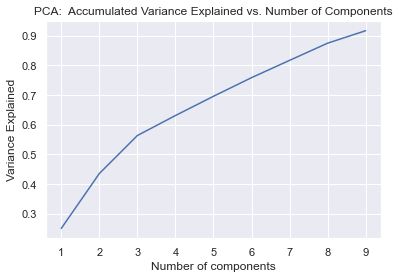

In [11]:
# Let's now test components from 1 to 10 and graph them with the accumulated explained variance

explained_variance = []

for n in range(1,10):
    pca = PCA(n_components=n)
    pca.fit(df_sample)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.plot(range(1,10), explained_variance)
plt.xlabel("Number of components")
plt.ylabel("Variance Explained")
plt.title("PCA:  Accumulated Variance Explained vs. Number of Components")
plt.show()

#### Conclusion:

With around 6 -7 components we could explain 80% of the variance, having 36 features is a good result.  
But, in our case, we want to graph the outcome of the clustering process.  
So we are going to reduce to only 2 dimensions or components. We are aware that the Accumulated Variance Explained is only 43.6%.  
But we accept it in order to graph them. If we would want to have a good reduction of the whole information dataset, 7 components would be  
the correct choice. But as is not going to be possible to graph them, we will continue with 2 dimensions.

#### Plot 2-D PCA

Let's show graphically the 2 components PCA.

In [12]:
principalComponents = pca_2.fit_transform(df_sample)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

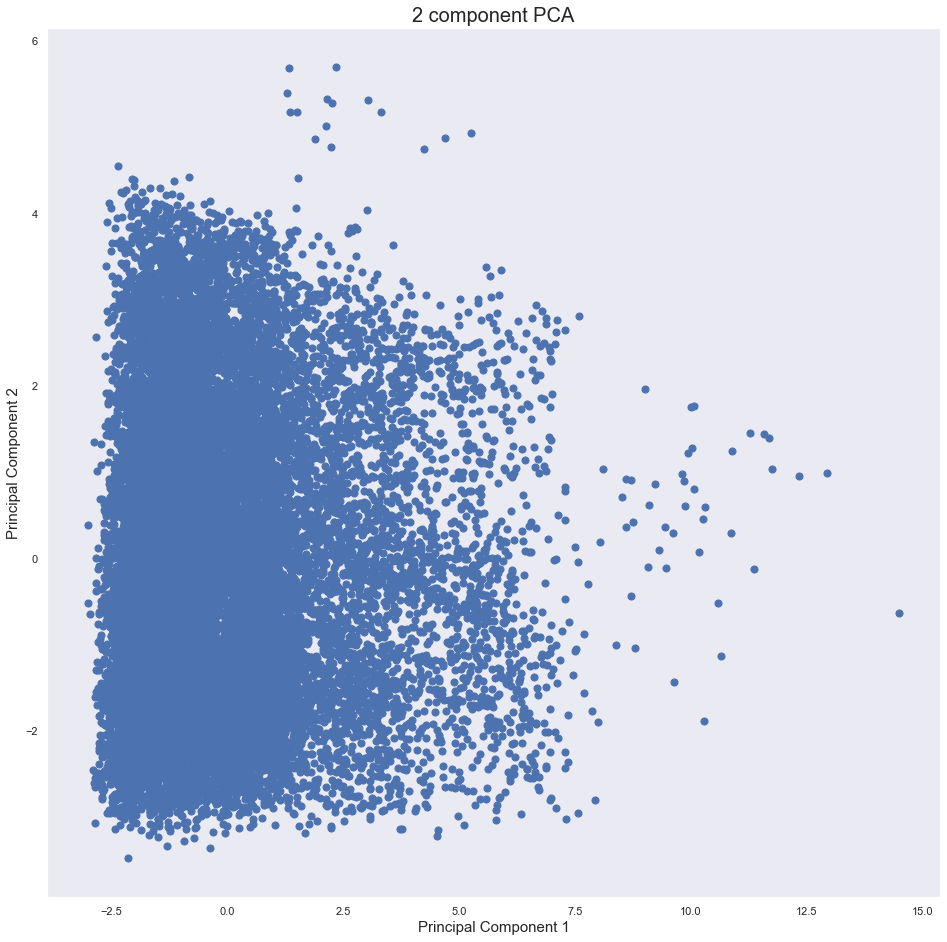

In [13]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1']
            , principalDf['principal component 2']
            , s = 50)
ax.grid()

### K - means clustering

K-Means is probably the most well-known clustering algorithm. It’s taught in a lot of introductory data science and machine learning classes.   
It’s easy to understand and implement in code! Check out the graphic below for an illustration.
 
----
![Kmeans](k-means.gif)

from: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68 


#### Cluster Number Determination

In the K-means algorithm, the most difficult thing is to determinate what is the number of cluster to use.  

We are going to use the kneed library.

In [14]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42 }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalDf)
    sse.append(kmeans.inertia_)

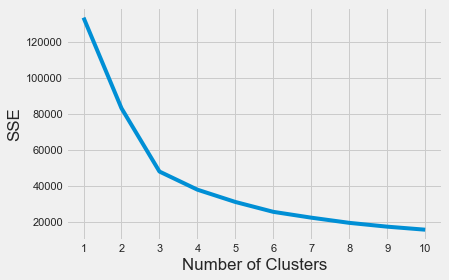

In [15]:
# Plot SSE
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Is quite straightforward that the optimal number of clusters is 3, for SSE but let's confirm it with Kneel elbow locator.

In [16]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("Optimal number of clusters: ",kl.elbow)

Optimal number of clusters:  3


Also KneeLocator confirms that the "elbow", optimal number of clusters, is 3.

Let's try now the silhouette coefficients score to determine the optimal number of clusters.

First, we will graph the silhouette score for the range 2 to 11 clusters.

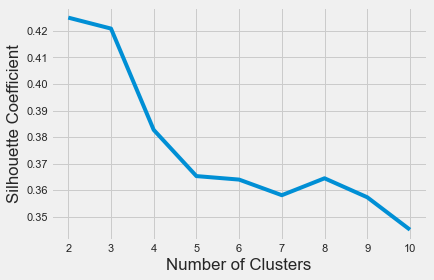

In [17]:
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalDf)
    score = silhouette_score(principalDf, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Observation:  
The best silhouette coefficient is for number of clusters = 2.  
But for SSE and KneeLocator the optimal number of clusters is 3.   
We will follow the results of these two indicators and use number of clusters = 3.

In [18]:
kmeans = KMeans(n_clusters= 3, **kmeans_kwargs)
kmeans.fit(principalDf)
score = silhouette_score(principalDf, kmeans.labels_)
print("Silhouette score of k-means with 3 clusters: %.3f"%score)

Silhouette score of k-means with 3 clusters: 0.421


Let's graph the 3 clusters in the 2D-diagram.

[0 1 2]


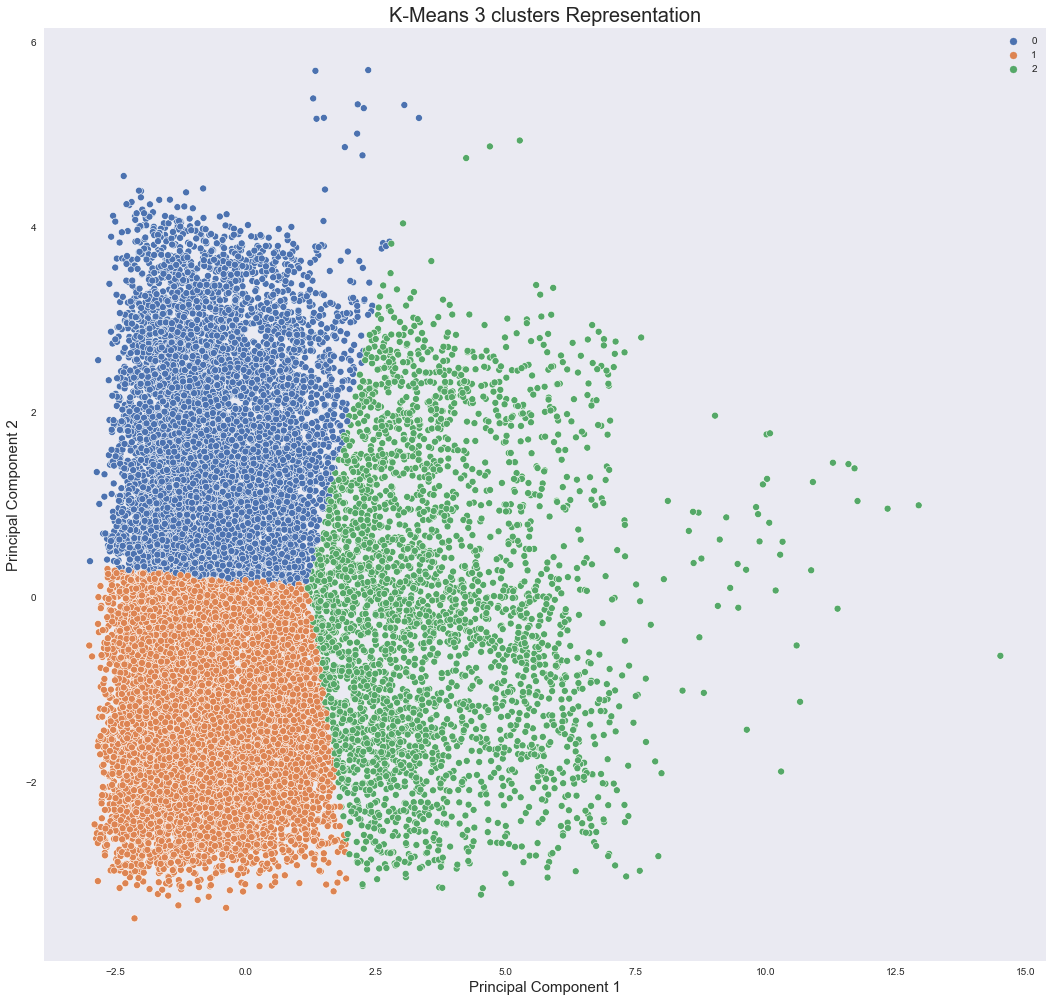

In [19]:
plt.style.use('seaborn') 
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('K-Means 3 clusters Representation', fontsize = 20)
sns.scatterplot(data= principalDf
                , x= 'principal component 1'
                , y= 'principal component 2'
                , hue= kmeans.labels_
                , palette="deep")

ax.grid()
print(np.unique(kmeans.labels_))
plt.legend()
plt.show()


# Level 2

## - Exercise 2
Group the different volumes using:
* hierarchical clustering algorithm 
    * Agglomerative
    * Divisive 
* Density-based clustering: E.g DBSCAN. 

We will use DBSCAN (as talked with mentor Laia Subirats)

DBSCAN - Density-Based Spatial Clustering of Applications with Noise.  
Finds core samples of high density and expands clusters from them.  
Good for data which contains clusters of similar density.  

![DBSCAN](DBSCAN.gif)


In [20]:
# Instantiate dbscan algorithms
dbscan = DBSCAN(eps=0.3)
# Fit the algorithms to the features
dbscan.fit(principalDf)
# Compute the silhouette scores for each algorithm
dbscan_silhouette = silhouette_score( principalDf, dbscan.labels_).round (2)

print("Silhouette score of DBSCAN with eps=0.3: %.3f"%dbscan_silhouette)

print(np.unique(dbscan.labels_))

Silhouette score of DBSCAN with eps=0.3: 0.320
[-1  0  1]


Let's graph the 4 clusters in the 2D-diagram.

[0 1 2]


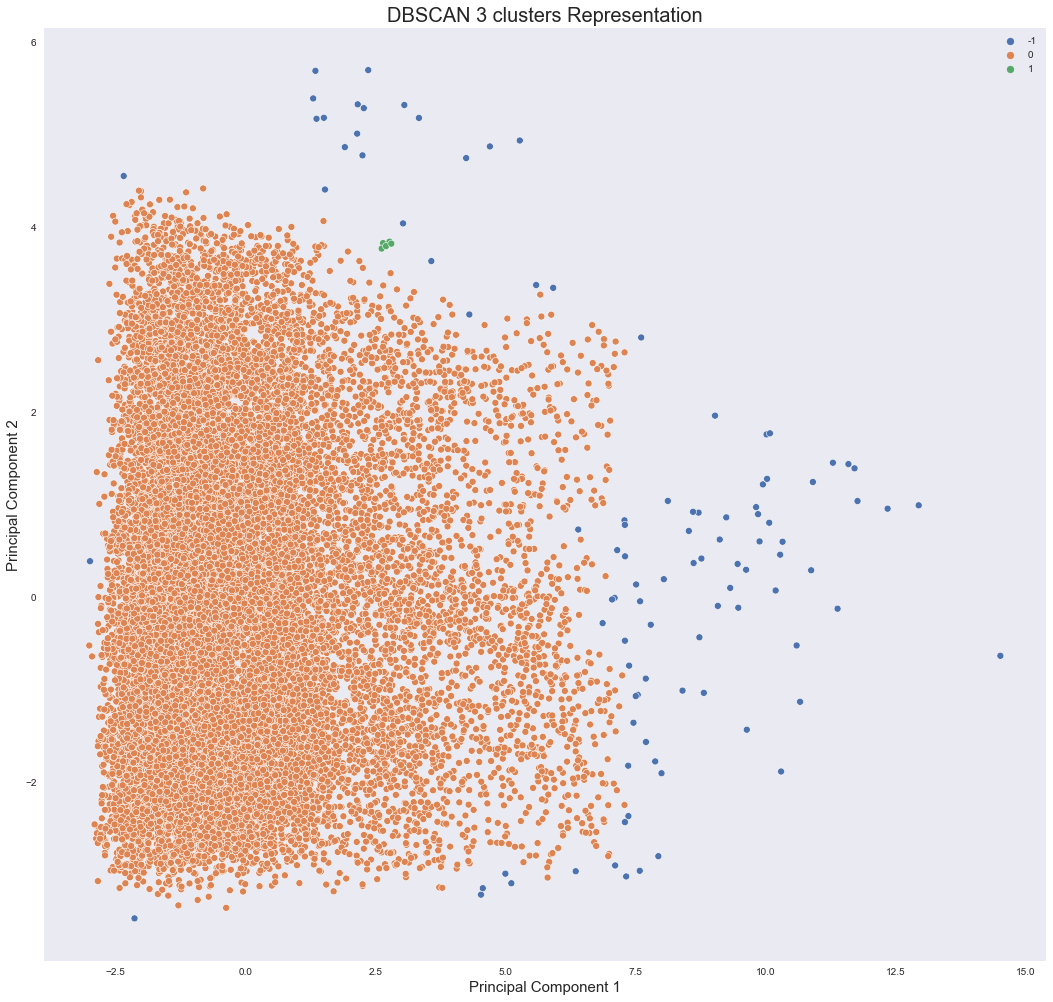

In [21]:
plt.style.use('seaborn') 
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('DBSCAN 3 clusters Representation', fontsize = 20)
sns.scatterplot(data= principalDf
                , x= 'principal component 1'
                , y= 'principal component 2'
                , hue= dbscan.labels_
                , palette="deep")

ax.grid()
print(np.unique(kmeans.labels_))
plt.legend()
plt.show()


# Level 3

## - Exercise 3
Calculate the performance of clustering using a parameter such as silhouette.

This has been calculated before. Now we put it together:


In [22]:
print("Silhouette score of k-means with 3 clusters: %.3f"%score)
print("Silhouette score of DBSCAN with 0.5 EBS: %.3f"%dbscan_silhouette)

Silhouette score of k-means with 3 clusters: 0.421
Silhouette score of DBSCAN with 0.5 EBS: 0.320


# Conclusion

It seems that, although DBSCAN has a lower performance using silhouette, its classification in clusters is more logical than k-means.
DBSCAN aggregates almost all info in 1 big cluster, and create 2 other clusters (-1,1) very minors, that could be just outlayers.

On the other hand, K-means gets a better silhouette performance, but graphically, the choose of the three clusters seem to be aleatory and incorrect.